In [1]:
import os

import colossus.cosmology.cosmology as colossus_cosmo
import colossus.lss.mass_function as colossus_mf
import colossus.halo.concentration as colossus_conc
from colossus.halo.profile_nfw import NFWProfile
from colossus.halo.profile_einasto import EinastoProfile
from colossus.halo.profile_dk14 import DK14Profile
from colossus.cosmology import cosmology as colossus_cosmo

from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const

from scipy.interpolate import interp1d
from scipy.integrate import quad

from AbundanceMatching import AbundanceFunction

In [2]:
cosmo = colossus_cosmo.setCosmology('planck15')
cosmo_astropy = FlatLambdaCDM(H0=cosmo.H0, Om0=cosmo.Om0, Ob0=cosmo.Ob0, Neff=cosmo.Neff, Tcmb0=cosmo.Tcmb0)

In [3]:
#DATA_DIR = os.curdir
DATA_DIR = '../SAGA/data/'
OUTPUT_DIR = os.path.join(os.getenv('HOME', os.curdir), 'Downloads')

## construct halo mass -- luminosity relation

/home/yymao/miniconda3/lib/python3.6/site-packages/AbundanceMatching/AbundanceFunction.py:232: RuntimeWarning: invalid value encountered in true_divide
  phi_int = dphi/_diff(phi_log_new)*dx


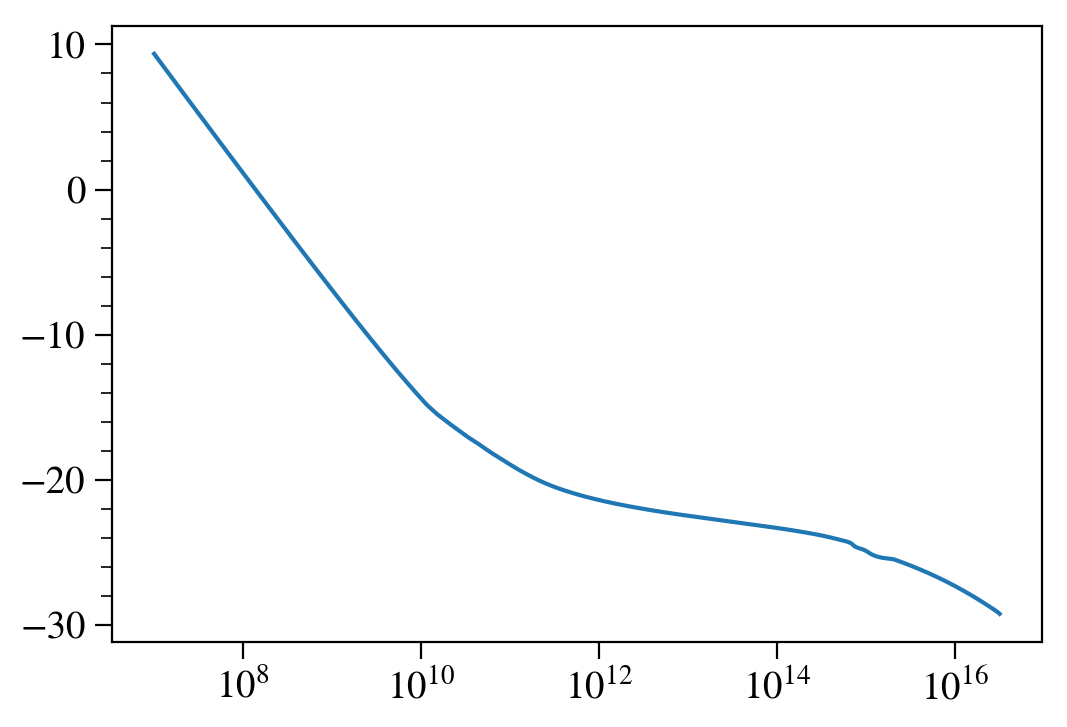

In [4]:
m = np.logspace(7, 16.5, 1001)[::-1]
n = np.cumsum(colossus_mf.massFunction(m, z=0.0, mdef='200c', q_out='dndlnM'))
n *= np.log(m[0]/m[1])
n *= cosmo.h**3.0

gama_lf = np.loadtxt(os.path.join(DATA_DIR, 'GAMA_LF.txt'), skiprows=1, usecols=(1, 2))
# convert from h=1 to h!=1 unit
gama_lf[:,0] += np.log10(cosmo.h) * 5.0
gama_lf[:,1] *= cosmo.h**3.0
af = AbundanceFunction(*gama_lf[0:-7].T, ext_range=(-30, 10), faint_end_fit_points=10)

log_mass_to_Mr = interp1d(np.log10(m[::-1]), af.match(n[::-1]), 'cubic')
plt.semilogx(m, log_mass_to_Mr(np.log10(m)))

## limiting redshift

In [5]:
z = np.concatenate([np.logspace(-6, -3, 31), np.linspace(0.001, 3, 1001)[1:]])
mu = cosmo.distanceModulus(z)
distmod_to_z = interp1d(mu, z,'cubic')

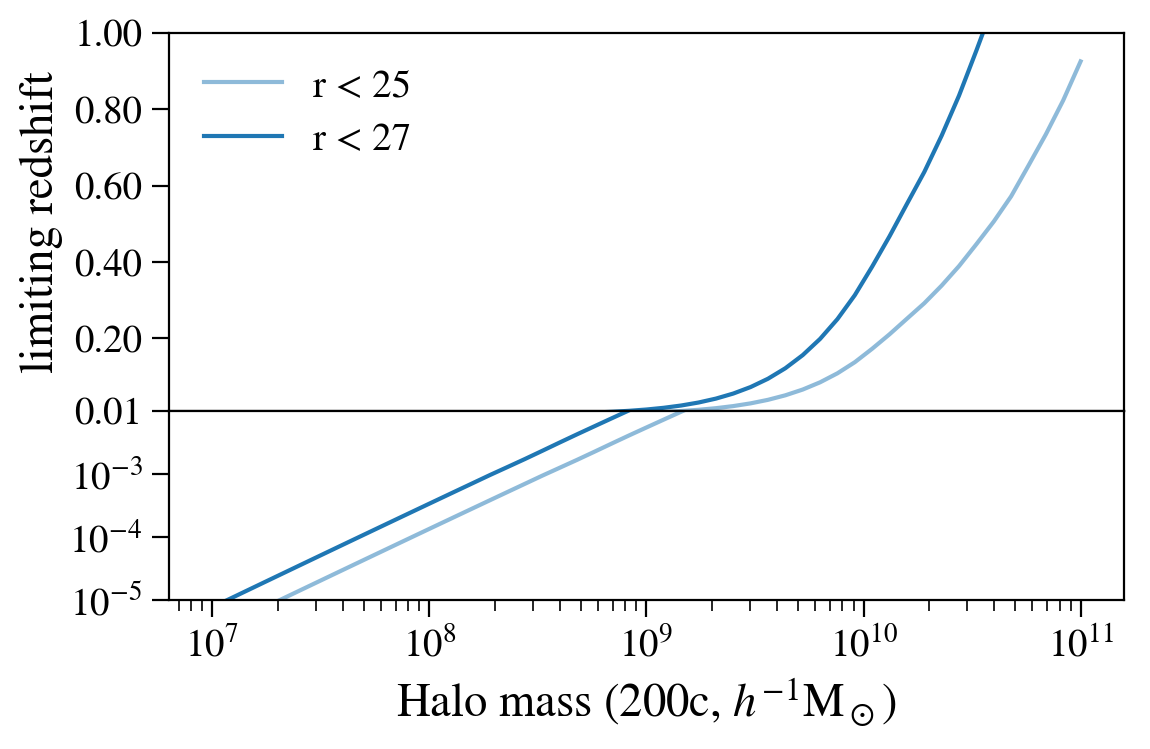

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[2,1]})
logm = np.linspace(7, 11, 51)
mag = log_mass_to_Mr(logm)
ax[0].semilogx(10.0**logm, distmod_to_z(25 - mag), label='r < 25', c='C0', alpha=0.5)
ax[0].semilogx(10.0**logm, distmod_to_z(27 - mag), label='r < 27', c='C0')
ax[1].loglog(10.0**logm, distmod_to_z(25 - mag), label='r < 25', c='C0', alpha=0.5)
ax[1].loglog(10.0**logm, distmod_to_z(27 - mag), label='r < 27', c='C0')
ax[1].set_xlabel('Halo mass (200c, $h^{-1}{\\rm M}_\\odot$)')
ax[0].set_ylabel('limiting redshift')
ax[0].set_ylim(0.01, 1)
ax[0].set_yticks([0.01, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[0].set_yticks([], minor=True)
ax[1].set_ylim(1e-5, 0.01)
ax[1].set_yticks([1e-5, 1e-4, 1e-3])
ax[0].legend()
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'halo_mass_redshift.pdf'))

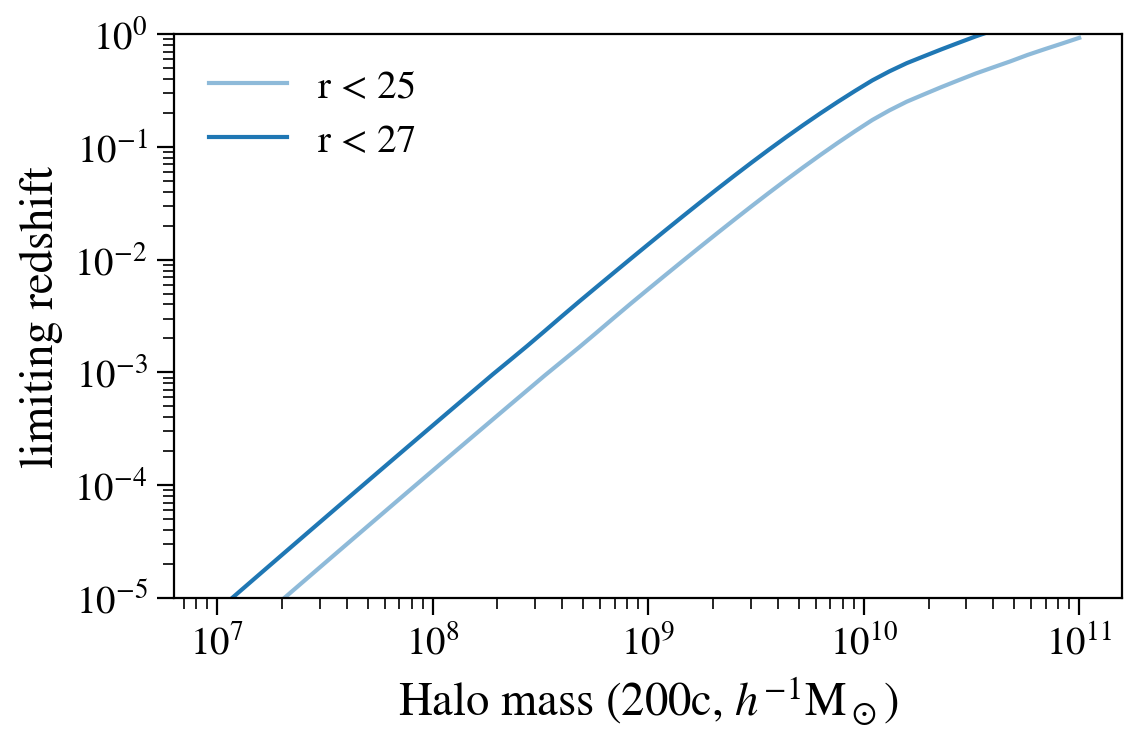

In [7]:
fig, ax = plt.subplots()
logm = np.linspace(7, 11, 51)
mag = log_mass_to_Mr(logm)
ax.loglog(10.0**logm, distmod_to_z(25 - mag), label='r < 25', c='C0', alpha=0.5)
ax.loglog(10.0**logm, distmod_to_z(27 - mag), label='r < 27', c='C0')
ax.set_xlabel('Halo mass (200c, $h^{-1}{\\rm M}_\\odot$)')
ax.set_ylabel('limiting redshift')
ax.set_ylim(1e-5, 1)
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'halo_mass_redshift_log.pdf'))

In [8]:
target_halo_mass = 1e10
dlogM = 0.5
dz = 0.1
limiting_mag = 27
sky_area = 16000

In [9]:
z_s = 1.2
n_eff = 50.0 # per arcmin^2
sigma_gamma = 0.25 # per component

In [10]:
rp_bin_edges = np.logspace(0, 3, 11)
rp_bin_mid = np.sqrt(rp_bin_edges[1:] * rp_bin_edges[:-1])

In [11]:
def Simga_cr(z_lens, z_source):
    DA_source = cosmo_astropy.angular_diameter_distance(z_source)
    DA_lens = cosmo_astropy.angular_diameter_distance(z_lens)
    DA_sl = cosmo_astropy.angular_diameter_distance_z1z2(z_lens, z_source)
    return (DA_source / (DA_lens * DA_sl * (1.0 + z_lens)**2.0) * (const.c * const.c / (4 * np.pi * const.G))).to("Msun / kpc**2").value / cosmo.h

In [12]:
def signal_to_noise(target_halo_mass):
    Mr = log_mass_to_Mr(np.log10(target_halo_mass))
    limiting_redshift = distmod_to_z(limiting_mag - Mr)
    limiting_redshift_low = max(0, limiting_redshift - dz)

    vol = 4. / 3. * np.pi * (cosmo.comovingDistance(z_max=limiting_redshift) ** 3 - cosmo.comovingDistance(z_max=limiting_redshift_low) ** 3)
    vol *= (sky_area / np.rad2deg(np.rad2deg(4*np.pi)))
    
    nd = quad(lambda ln_m: colossus_mf.massFunction(np.exp(ln_m), z=limiting_redshift, mdef='200c', q_out='dndlnM'), 
              np.log(target_halo_mass), np.log(target_halo_mass*10.0**dlogM))[0] * cosmo.h**3.0 
    
    n_lens = vol * nd
    conc = colossus_conc.concentration(target_halo_mass, '200c', limiting_redshift, model='diemer18')
    print('m200c={:.0E}, z={:.4f}, n={:.2E}, Mr={:.1f}, c={:.2f}'.format(target_halo_mass, limiting_redshift, n_lens, Mr, conc))
    
    rp_bin_edges_arcmin = np.rad2deg(rp_bin_edges / cosmo.angularDiameterDistance(limiting_redshift) / 1000.0) * 60
    annulus_area_arcmin = np.pi * (rp_bin_edges_arcmin[1:]**2 - rp_bin_edges_arcmin[:-1]**2)

    n_src = annulus_area_arcmin * n_eff
    n_lens_src = n_src * n_lens
    shape_noise = sigma_gamma / np.sqrt(n_lens_src)

    halo = NFWProfile(M=target_halo_mass, c=conc, z=limiting_redshift, mdef='200c')
    halo1 = CoreNFW(rhos=halo.par['rhos'], rs=halo.par['rs'])
    
    Scr = Simga_cr(limiting_redshift, z_s)
    kappa = halo.surfaceDensity(rp_bin_mid)/Scr
    gamma = halo.deltaSigma(rp_bin_mid)/Scr
    g_t = gamma / (1.0-kappa)
    
    kappa = halo1.surfaceDensity(rp_bin_mid)/Scr
    gamma = halo1.deltaSigma(rp_bin_mid)/Scr
    g_t1 = gamma / (1.0-kappa)
    
    return g_t, g_t1, shape_noise

In [13]:
from colossus.halo import profile_base

class CoreNFW(profile_base.HaloDensityProfile):

    def __init__(self, rhos, rs):

        self.par_names = ['rhos', 'rs']
        self.opt_names = []
        profile_base.HaloDensityProfile.__init__(self)

        self.par['rhos'] = rhos
        self.par['rs'] = rs

        return

    def densityInner(self, r):

        x = r / self.par['rs']
        density = self.par['rhos'] / x / (1.0 + x)**2 * (1.0 - np.exp(-r/self.par['rs']*3))

        return density

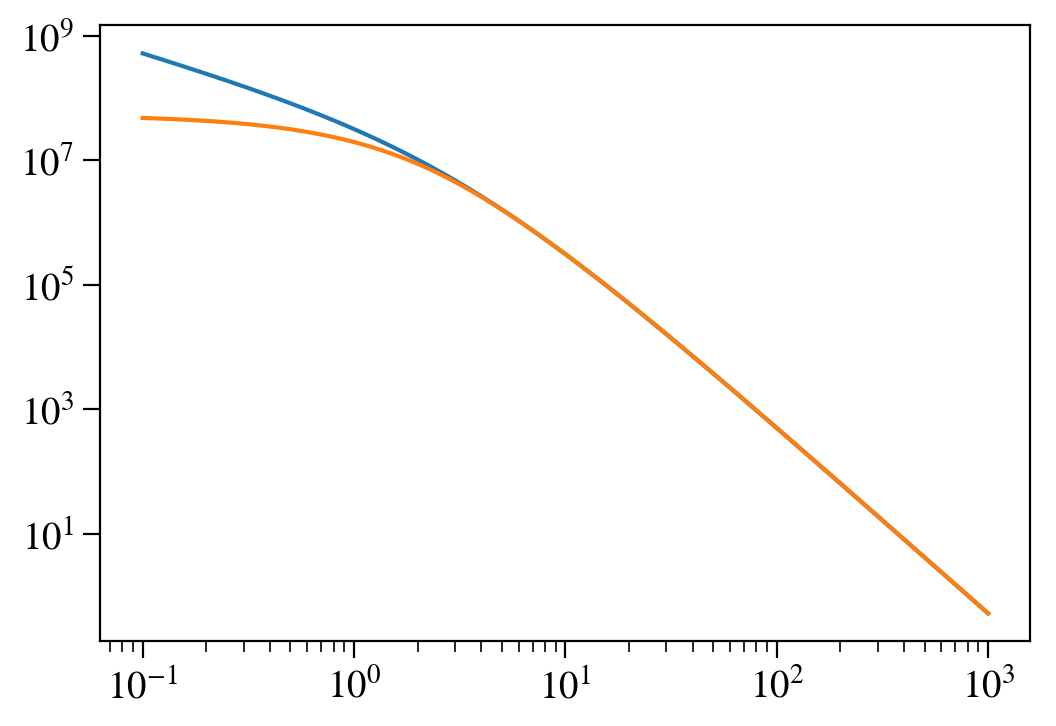

In [14]:
halo = NFWProfile(M=1e10, c=10, z=0.34, mdef='200c')
halo1 = CoreNFW(rhos=halo.par['rhos'], rs=halo.par['rs'])

r = np.logspace(-1, 3, 101)
plt.loglog(r, halo.density(r))
plt.loglog(r, halo1.density(r))

m200c=1E+10, z=0.3490, n=3.77E+07, Mr=-14.4, c=10.76
m200c=3E+09, z=0.0718, n=2.43E+06, Mr=-10.6, c=13.72
m200c=1E+09, z=0.0136, n=5.05E+04, Mr=-6.9, c=15.38


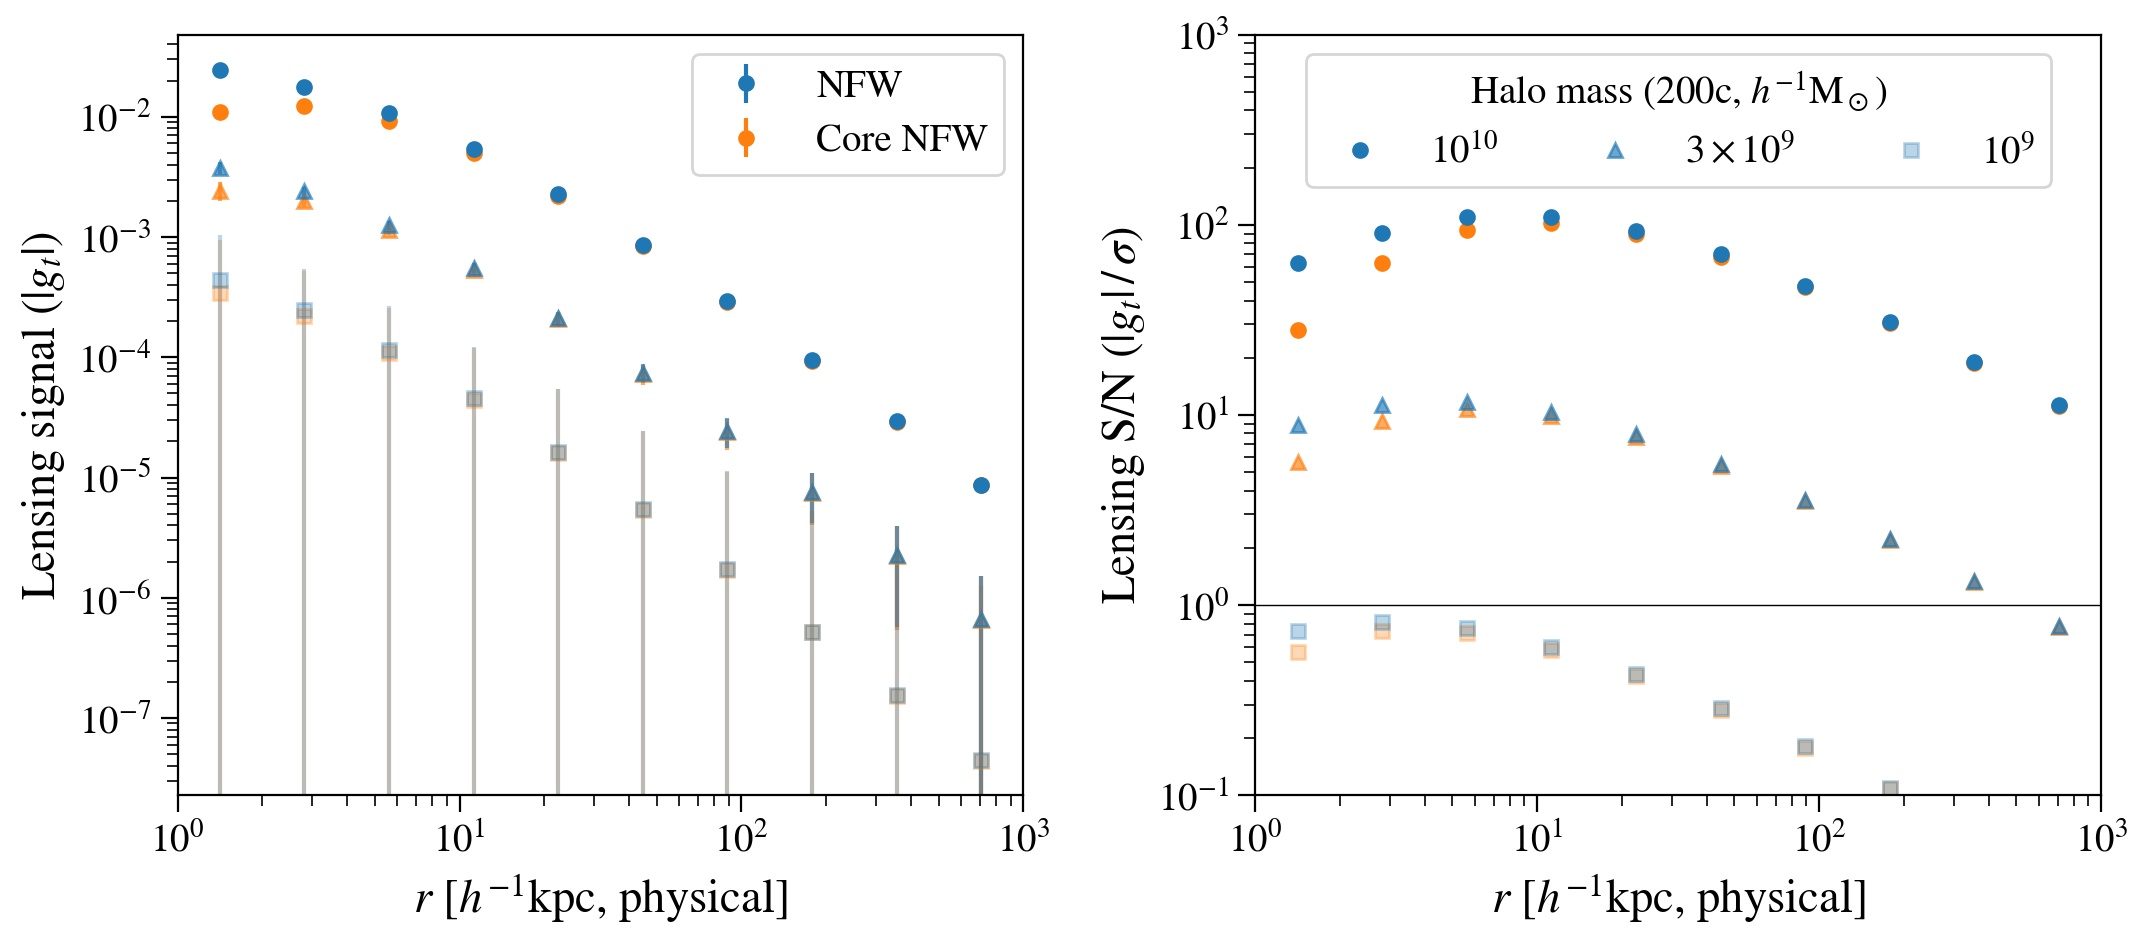

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(11,5))

g1, g2, shape_noise = signal_to_noise(1e10)

ax[0].errorbar(rp_bin_mid, g1, yerr=shape_noise, c='C0', label='NFW', alpha=1, marker='o', ls='', ms=5, zorder=99)
ax[0].errorbar(rp_bin_mid, g2, yerr=shape_noise, c='C1', label='Core NFW', alpha=1, marker='o', ls='', ms=5)
ax[1].loglog(rp_bin_mid, g2/shape_noise, c='C1', alpha=1, marker='o', ls='', ms=5)
ax[1].loglog(rp_bin_mid, g1/shape_noise, label='$10^{10}$', c='C0', alpha=1, marker='o', ls='', ms=5)
g1, g2, shape_noise = signal_to_noise(3e9)
ax[0].errorbar(rp_bin_mid, g2, yerr=shape_noise, c='C1', alpha=0.65, marker='^', ls='', ms=5)
ax[0].errorbar(rp_bin_mid, g1, yerr=shape_noise, c='C0', alpha=0.65, marker='^', ls='', ms=5)
ax[1].loglog(rp_bin_mid, g2/shape_noise, c='C1', alpha=0.65, marker='^', ls='', ms=5)
ax[1].loglog(rp_bin_mid, g1/shape_noise, label='$3\\times10^9$', c='C0', alpha=0.65, marker='^', ls='', ms=5)
g1, g2, shape_noise = signal_to_noise(1e9)
ax[0].errorbar(rp_bin_mid, g2, yerr=shape_noise, c='C1', alpha=0.3, marker='s', ls='', ms=5)
ax[0].errorbar(rp_bin_mid, g1, yerr=shape_noise, c='C0', alpha=0.3, marker='s', ls='', ms=5)
ax[1].loglog(rp_bin_mid, g2/shape_noise, c='C1', alpha=0.3, marker='s', ls='', ms=5)
ax[1].loglog(rp_bin_mid, g1/shape_noise, label='$10^9$', c='C0', alpha=0.3, marker='s', ls='', ms=5)


ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$r$ [$h^{-1}$kpc, physical]')
ax[0].set_ylabel('Lensing signal ($|g_t|$)')
ax[1].set_xlabel('$r$ [$h^{-1}$kpc, physical]')
ax[1].set_ylabel('Lensing S/N ($|g_t|\,/\,\sigma$)')
ax[0].legend(frameon=True)
ax[1].legend(title='Halo mass (200c, $h^{-1}{\\rm M}_\\odot$)', ncol=3, loc='upper center', frameon=True)
ax[0].set_xlim(1, 1000)
ax[1].set_xlim(1, 1000)

ax[1].set_ylim(1e-1, 1000)

ax[1].axhline(1, c='k', lw=0.5)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'halo_mass_lensing_sn.pdf'))